# Tratamento da base de dados

In [ ]:
# Baseado em https://github.com/ChandraLingam/AmazonSageMakerCourse/tree/master/DeepAR/BikeRental
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
import numpy as np
import datetime

In [ ]:
# https://www.kaggle.com/competitions/bike-sharing-demand/data
base = pd.read_csv('./csv_files/train.csv')
base

Para trabalhar com leituras temporais, precisamos da coluna datetime no formato de data e não string/int

In [ ]:
# Considerando as datas como indices 
base = pd.read_csv('./csv_files/train.csv', parse_dates=['datetime'], index_col=0)
base

In [ ]:
base.drop(columns = ['season', 'holiday','workingday','weather','temp','atemp', 'humidity','windspeed','casual', 'registered'], axis=1, inplace = True)
base

In [ ]:
# Agrupando numa frequencia Diaria D
base = base.groupby(pd.Grouper(freq = 'D')).sum()
base

In [ ]:
base_teste = base.copy()
base_teste.shape

No DeepAR o modelo será treinado com menos registros do que será testado.

In [ ]:
base_treinamento = base.iloc[0:689,:]
base_treinamento

In [ ]:
base_treinamento.index.min(), base_treinamento.index.max()

In [ ]:
base_teste.index.min(), base_teste.index.max()

Convertendo para o tipo de dado aceito no DeepAR

In [ ]:
# Creating timestamps without the 'freq' parameter
dt_data_inicial = pd.Timestamp("2011-01-01")
dt_data_final_treinamento = pd.Timestamp("2012-11-19")
dt_previsao_maxima = pd.Timestamp("2012-12-19")

# Creating tuples for training and testing ranges
faixa_treinamento = (dt_data_inicial, dt_data_final_treinamento)
faixa_teste = (dt_data_inicial, dt_previsao_maxima)

print(faixa_treinamento)
print(faixa_teste)

Necessario que os dados estejam no formato de lista

In [ ]:
serie_temporal_treinamento = []
serie_temporal_teste = []

# Posicao 0 da tupla igual inicio - Posicao 1 = fim
serie_temporal_treinamento.append(base_treinamento[faixa_treinamento[0]:faixa_treinamento[1]]['count'])
serie_temporal_teste.append(base_teste[faixa_teste[0]:faixa_teste[1]]['count'])

In [ ]:
type(serie_temporal_treinamento), type(serie_temporal_teste)

In [ ]:
serie_temporal_treinamento

In [ ]:
len(serie_temporal_treinamento[0]), len(serie_temporal_teste[0])

In [ ]:
plt.figure(figsize=(10,10))
serie_temporal_teste[0].plot(label = "Teste")
serie_temporal_treinamento[0].plot(label = "Treinamento")
plt.legend()
plt.show()

In [ ]:
# Function para eliminar valores invalidos
def encode_target(ts):
    return [x if np.isfinite(x) else "NaN" for x in ts]

encode_target(serie_temporal_treinamento[0][0:25])

In [ ]:
# Convertendo para o formato aceito pelo DeepAR
def series_to_obj(ts):
    obj = {"start": str(ts.index[0]), "target": encode_target(ts)}
    return obj

series_to_obj(serie_temporal_treinamento[0][0:5])

In [ ]:
def series_to_jsonline(ts):
    return json.dumps(series_to_obj(ts))

series_to_jsonline(serie_temporal_treinamento[0][0:5])

Criando um Json com a base de teste e base de treinamento

In [ ]:
encoding = 'utf-8'
arquivo_json_treinamento = 'train.json'
arquivo_json_teste = 'test.json'
with open(arquivo_json_treinamento, 'wb') as fp:
    for ts in serie_temporal_treinamento:
        fp.write(series_to_jsonline(ts).encode(encoding))
        fp.write('\n'.encode(encoding))

with open(arquivo_json_teste, 'wb') as fp:
    for ts in serie_temporal_teste:
        fp.write(series_to_jsonline(ts).encode(encoding))
        fp.write('\n'.encode(encoding))

# Confiurações SageMaker

In [ ]:
import boto3
import sagemaker
import os

In [ ]:
session = sagemaker.Session()
print(sagemaker.get_execution_role())

job_name = 'deepar-bike'
bucket = 'sagemaker-curso-bucket'

subpasta_modelo = 'modelos/bike/deepar'
subpasta_dataset = 'datasets/bike'


role = "AmazonSageMaker-ExecutionRole-20240702T173175"

s3_train_data = 's3://{}/{}/train/{}'.format(bucket, subpasta_dataset, 'train.json')
s3_test_data = 's3://{}/{}/test/{}'.format(bucket, subpasta_dataset, 'test.json')
output_location = 's3://{}/{}/output'.format(bucket, subpasta_modelo)
print('Localização da base de dados de treinamento: ', s3_train_data)
print('Localização da base de dados de test: ', s3_test_data)
print('Modelo final será salvo em: ', output_location)

In [ ]:
def escreve_s3(arquivo, bucket, nome):
    with open(arquivo, 'rb') as f:
        return boto3.Session().resource('s3').Bucket(bucket).Object(nome).upload_fileobj(f)

In [ ]:
escreve_s3('train.json', bucket, os.path.join(subpasta_dataset, 'train', 'train.json'))
escreve_s3('test.json', bucket, os.path.join(subpasta_dataset, 'test', 'test.json'))

# Treinamento do DeepAR

In [ ]:
# https://docs.aws.amazon.com/sagemaker/latest/dg/ecr-sa-east-1.html
container = sagemaker.image_uris.retrieve(framework = 'forecasting-deepar', region = session.boto_region_name)

In [ ]:
# https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html
# https://github.com/aws-samples/amazon-sagemaker-managed-spot-training/blob/main/xgboost_built_in_managed_spot_training_checkpointing/xgboost_built_in_managed_spot_training_checkpointing.ipynb
deepar = sagemaker.estimator.Estimator(image_uri = container,
                                       role = role,
                                       instance_count = 1,
                                       instance_type = 'ml.m5.large',
                                       output_path = output_location,
                                       sagemaker_session = session,
                                       base_job_name = job_name,
                                       use_spot_instances = True,
                                       max_run = 3600,
                                       max_wait = 3600)

In [ ]:
# https://docs.aws.amazon.com/sagemaker/latest/dg/deepar_hyperparameters.html
freq = 'D'
prediction_length = 30
context_length = 30

hyperparametros = {
    'time_freq': freq, # Frequencia dos Dados
    'epochs': "20", # Treinar o modelo por 20 epocas
    'context_length': str(context_length), 
    'prediction_length': str(prediction_length)
}

deepar.set_hyperparameters(**hyperparametros)

In [ ]:
data_channels = {'train': s3_train_data, 'test': s3_test_data}
data_channels

In [ ]:
deepar.fit(inputs = data_channels)

# Deploy e previsões

Deploy:

In [ ]:
job_name = deepar.latest_training_job.name
print('Job name: ', job_name)

endpoint = session.endpoint_from_job(job_name = job_name,
                                     initial_instance_count = 1,
                                     instance_type = "ml.m5.large",
                                     image_uri = container,
                                     role = role)

print('Endpoint: ', endpoint)

## Configurações do DeepAR:

Código fornecido pela documentação AWS

In [ ]:
class DeepARPredictor(sagemaker.predictor.Predictor):

    def set_prediction_parameters(self, freq, prediction_length):
        """Set the time frequency and prediction length parameters. 
          This method **must** be called before being able to use `predict`.
        
        Parameters:
        freq -- string indicating the time frequency
        prediction_length -- integer, number of predicted time points
        
        Return value: none.
        """
        self.freq = freq
        self.prediction_length = prediction_length
        
    def predict(self, ts, cat=None, dynamic_feat=None, 
                encoding="utf-8", num_samples=100, quantiles=["0.1", "0.5", "0.9"]):
        """Requests the prediction of for the time series listed in `ts`, 
           each with the (optional) corresponding category listed in `cat`.
        
        Parameters:
        ts -- list of `pandas.Series` objects, the time series to predict
        cat -- list of integers (default: None)
        encoding -- string, encoding to use for the request (default: "utf-8")
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        quantiles -- list of strings specifying the quantiles to compute (default: ["0.1", "0.5", "0.9"])
        
        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        prediction_times = [x.index[-1] + datetime.timedelta(hours=1) for x in ts] 
        
        req = self.__encode_request(ts, cat, dynamic_feat, encoding, num_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, prediction_times, encoding)
    
    def __encode_request(self, ts, cat, dynamic_feat, encoding, num_samples, quantiles):
        
        instances = [series_to_obj(ts[k]) for k in range(len(ts))]
        
        configuration = {"num_samples": num_samples, "output_types": ["quantiles"], "quantiles": quantiles}
        http_request_data = {"instances": instances, "configuration": configuration}
        return json.dumps(http_request_data).encode(encoding)
    
    def __decode_response(self, response, prediction_times, encoding):
        response_data = json.loads(response.decode(encoding))
        list_of_df = []
        for k in range(len(prediction_times)):
            prediction_index = pd.date_range(start=prediction_times[k], freq=self.freq, periods=self.prediction_length)
            list_of_df.append(pd.DataFrame(data=response_data['predictions'][k]['quantiles'], index=prediction_index))
        return list_of_df

In [ ]:
predictor = DeepARPredictor(endpoint_name = 'deepar-bike-2022-05-19-19-15-14-057',
                            sagemaker_session = session)
predictor.set_prediction_parameters(freq, prediction_length)
predictor.serializer.content_type = "application/json"

Iniciando previsões:

In [ ]:
previsoes = predictor.predict(serie_temporal_treinamento)

In [ ]:
previsoes

0.5 - são as previsões (mediana)

In [ ]:
[                             0.1          0.5          0.9
 2012-11-19 01:00:00    81.751160  1021.147034  1941.947632
 2012-11-20 01:00:00  -477.450104  -126.183731   200.116821
 2012-11-21 01:00:00  -192.595276   -62.932251   102.896500
 2012-11-22 01:00:00   -83.179741   -10.409641   100.315605
 2012-11-23 01:00:00  -117.356873   -38.689064    32.051506
 2012-11-24 01:00:00  -120.325974   -45.842602    30.433727
 2012-11-25 01:00:00   -71.074921     8.277226   105.337250
 2012-11-26 01:00:00  -110.271332   -50.417408    40.498543
 2012-11-27 01:00:00  -226.430984   -61.401958    66.499580
 2012-11-28 01:00:00  -182.769867   -40.222404   144.569168
 2012-11-29 01:00:00   -82.768921   285.667725   774.222046
 2012-11-30 01:00:00  1024.545654  2135.741211  3839.138916
 2012-12-01 01:00:00  2883.889648  4239.021484  5993.821777
 2012-12-02 01:00:00  2838.771240  5567.348633  7744.334961
 2012-12-03 01:00:00  3737.095947  5737.732910  7799.645508
 2012-12-04 01:00:00  4021.275391  5699.877930  6996.214355
 2012-12-05 01:00:00  4028.331299  5529.660156  6724.604004
 2012-12-06 01:00:00  4658.131836  5640.213379  7340.486816
 2012-12-07 01:00:00  4400.713379  5621.302246  7204.938477
 2012-12-08 01:00:00  4487.339844  5593.937012  6657.020996
 2012-12-09 01:00:00  4685.892578  5710.781738  6917.207520
 2012-12-10 01:00:00  4780.791016  5814.346191  6873.307129
 2012-12-11 01:00:00  4682.760254  5631.159180  7008.041992
 2012-12-12 01:00:00  4747.140625  5810.919922  7114.795898
 2012-12-13 01:00:00  4787.459961  5948.392090  7101.114746
 2012-12-14 01:00:00  4505.422363  5705.535645  6812.600586
 2012-12-15 01:00:00  4486.506836  5719.681641  7035.645996
 2012-12-16 01:00:00  4723.630859  5766.337402  7069.052246
 2012-12-17 01:00:00  3612.868164  5775.592285  7542.102539
 2012-12-18 01:00:00  2061.799805  4414.260254  6524.545898]

In [ ]:
for k in range(len(previsoes)):
    plt.figure(figsize=(12,6))
    previsoes[k]['0.5'].plot(label = 'Mediana', color = 'red')
    #serie_temporal_teste[k].plot(label = 'Alvo')
    serie_temporal_teste[k][-prediction_length - context_length:].plot(label = 'Alvo')
    p10 = previsoes[k]['0.1']
    p90 = previsoes[k]['0.9']
    plt.fill_between(p10.index, p10, p90, color = 'y', alpha = 0.5, label = 'Intervalo de confiança')
    plt.legend()
    plt.show()

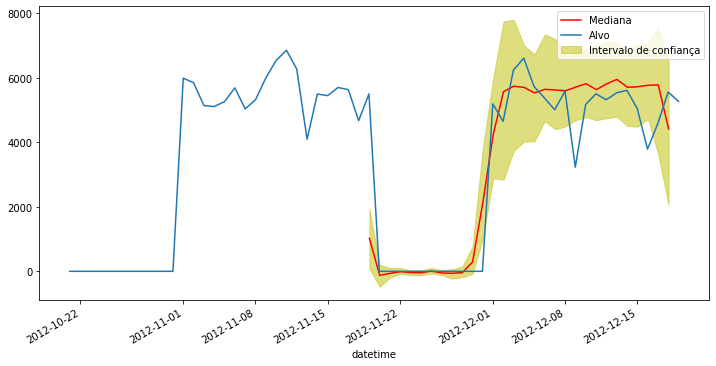

Quanto menor largo o intervalo de confiança, mais precisas serão as previsoes.

Linha de alvo e mediana proximas indicam boa acertividade do modelo.

Treinamento por mais epocas, gera um intervalo de confiança melhor.